# Create a Seurat object with only relevant data for the combinations

In [ ]:
library(Seurat)
library(tidyverse)
source("functions-combinations.R")

In [ ]:
Seurat_int <- readRDS(file.path(data_folder, "C3H10_10X_all_exps_merged_genefiltered_50pc_integrated.rds"))

In [ ]:
seu <- Seurat_int[, (
  ((Seurat_int@meta.data$batch %in% c("exp07", "exp08", "exp09")) & (Seurat_int@meta.data$TF %in% c("D0"))) |
    ((Seurat_int@meta.data$batch %in% c("exp12-13")) & !(Seurat_int@meta.data$TF %in% c("D0")))
)]

seu@meta.data$cell <- rownames(seu@meta.data)

# qc about the phase and TF
seu <- seu %>% FindVariableFeatures() %>% ScaleData() %>% RunPCA() %>% RunUMAP(dims = 1:20)
seu$controls <- ifelse(seu$TF == "D0", "D0", ifelse(seu$TF == "D0_confluent", "D0_confluent", "TF"))

Centering and scaling data matrix

PC_ 1 
Positive:  ENSMUSG00000061723, ENSMUSG00000026414, ENSMUSG00000030672, ENSMUSG00000009214, ENSMUSG00000017300, ENSMUSG00000064179, ENSMUSG00000031097, ENSMUSG00000026418, ENSMUSG00000031972, ENSMUSG00000030730 
	   ENSMUSG00000091898, ENSMUSG00000020216, ENSMUSG00000020722, ENSMUSG00000026459, ENSMUSG00000038239, ENSMUSG00000079471, ENSMUSG00000030399, ENSMUSG00000108322, ENSMUSG00000051747, ENSMUSG00000075307 
	   ENSMUSG00000044086, ENSMUSG00000026253, ENSMUSG00000026950, ENSMUSG00000027107, ENSMUSG00000061086, ENSMUSG00000042451, ENSMUSG00000018893, ENSMUSG00000068614, ENSMUSG00000039376, ENSMUSG00000022519 
Negative:  ENSMUSG00000040204, ENSMUSG00000001525, ENSMUSG00000017716, ENSMUSG00000020914, ENSMUSG00000028312, ENSMUSG00000026238, ENSMUSG00000031004, ENSMUSG00000054717, ENSMUSG00000028832, ENSMUSG00000068101 
	   ENSMUSG00000021377, ENSMUSG00000025574, ENSMUSG00000022033, ENSMUSG00000062248, ENSMUSG00000019942, ENSMUSG00000049932, ENSM

In [ ]:
seu$log_vector <- log(seu$Vector_UMI + 1)

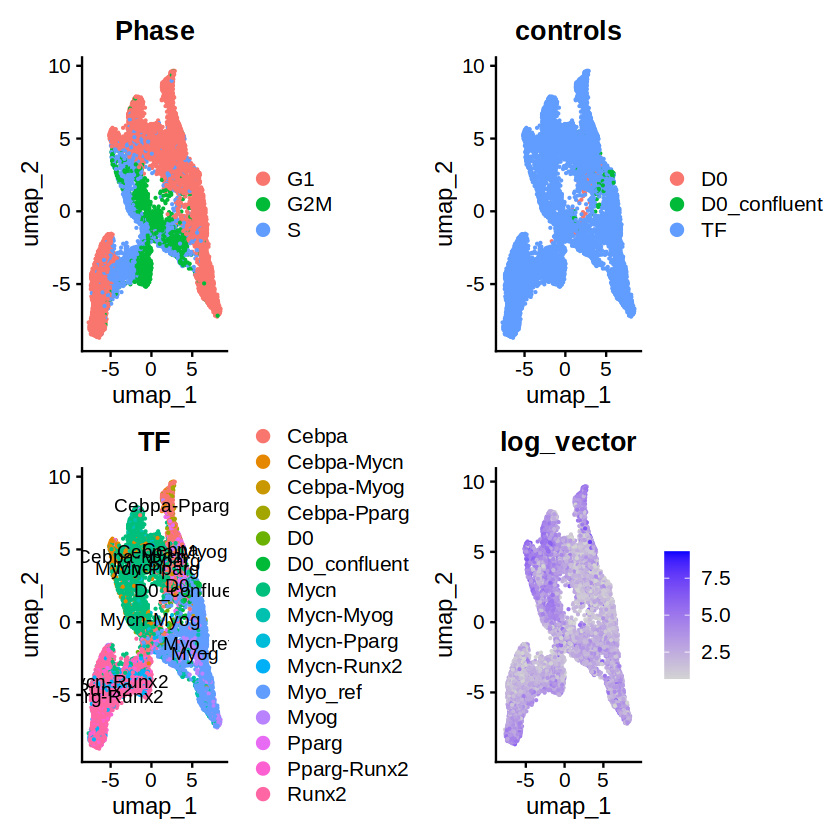

In [ ]:

plot <- patchwork::wrap_plots(
  DimPlot(seu, group.by = "Phase"),
  DimPlot(seu, group.by = "controls"),
  DimPlot(seu, group.by = "TF", label = TRUE),
  FeaturePlot(seu, "log_vector")
)
plot


In [ ]:
# load the annotatons of genes and add it to the seurat object
# TODO: Should be replaced
data.annot <- read.csv(file.path(data_folder, "var.csv"), sep = ",")
rownames(data.annot) <- data.annot$gene
seu@assays$RNA@meta.features <- data.annot

### Get TF/barcode counts
## Get enrichment data and put it in the seurat object

In [ ]:
library(data.table)
x_df <- fread(file.path(data_folder, "C3H10_10X_exp12-13_enriched.read_matrix.txt"))

x <- as.matrix(x_df[, 3:ncol(x_df)])
rownames(x) <- x_df$TFId
colnames(x) <- paste0(colnames(x), "-12-13")

In [ ]:

# calculate both "oe_reads" and "bc_reads"
TFs <- tibble(TF = unique(map_chr(str_split(rownames(x), "_"), 1)))
conditions <- tibble(condition = factor(unique(seu$TF)))

y <- tibble(cell = colnames(x))

for (TF in TFs$TF) {
  y[[TF]] <- colSums(x[startsWith(rownames(x), TF), ])
}

y <- y %>% 
  filter(cell %in% seu@meta.data$cell) %>% 
  complete(cell = rownames(seu@meta.data)) %>% 
  mutate_all(replace_na, 0) %>% 
  mutate(order = match(cell, seu@meta.data$cell)) %>% 
  arrange(order)

oe_assay <- CreateAssayObject(counts = y %>% select(-order) %>% column_to_rownames("cell") %>% as.matrix() %>% t)
seu[["oereads"]] <- oe_assay

y_bc <- tibble(cell = colnames(x))
for (bc in rownames(x)) {
  y_bc[[bc]] <- as.numeric(x[bc, ])
}
y_bc <- y_bc %>% 
  filter(cell %in% seu@meta.data$cell) %>% 
  complete(cell = rownames(seu@meta.data)) %>% 
  mutate_all(replace_na, 0) %>% 
  mutate(order = match(cell, seu@meta.data$cell)) %>% 
  arrange(order)

bc_assay <- CreateAssayObject(counts = y_bc %>% select(-order) %>% column_to_rownames("cell") %>% as.matrix() %>% t)
seu[["bcreads"]] <- bc_assay

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”


In [ ]:
library(data.table)
x_df <- fread(file.path(data_folder, "C3H10_10X_exp12-13_enriched.umi_matrix.txt"))

x <- as.matrix(x_df[, 3:ncol(x_df)])
rownames(x) <- x_df$TFId
colnames(x) <- paste0(colnames(x), "-12-13")

In [ ]:
# calculate both "oe_reads" and "bc_reads"
TFs <- tibble(TF = unique(map_chr(str_split(rownames(x), "_"), 1)))
conditions <- tibble(condition = factor(unique(seu$TF)))

y <- tibble(cell = colnames(x))

for (TF in TFs$TF) {
  y[[TF]] <- colSums(x[startsWith(rownames(x), TF), ])
}

y <- y %>% 
  filter(cell %in% seu@meta.data$cell) %>% 
  complete(cell = rownames(seu@meta.data)) %>% 
  mutate_all(replace_na, 0) %>% 
  mutate(order = match(cell, seu@meta.data$cell)) %>% 
  arrange(order)

oe_assay <- CreateAssayObject(counts = y %>% select(-order) %>% column_to_rownames("cell") %>% as.matrix() %>% t)
seu[["oeumi"]] <- oe_assay

y_bc <- tibble(cell = colnames(x))
for (bc in rownames(x)) {
  y_bc[[bc]] <- as.numeric(x[bc, ])
}
y_bc <- y_bc %>% 
  filter(cell %in% seu@meta.data$cell) %>% 
  complete(cell = rownames(seu@meta.data)) %>% 
  mutate_all(replace_na, 0) %>% 
  mutate(order = match(cell, seu@meta.data$cell)) %>% 
  arrange(order)

bc_assay <- CreateAssayObject(counts = y_bc %>% select(-order) %>% column_to_rownames("cell") %>% as.matrix() %>% t)
seu[["bcumi"]] <- bc_assay

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”


In [ ]:
write_rds(seu, file.path(output_folder, "seu.rds"))